# 📉 Spectral Analysis of Random Matrices: Wigner's Semicircle Law

**Notebook Update (2026):** Yacine  
**Original Project (2024):** Yacine, Octave & Roman  
**Affiliation:** Dual Degree Candidate - ENS de Lyon (Physics) & École des Ponts ParisTech (Applied Maths/CS)  
**Documentation:** [**Read the Original 2024 Project Report**](./Ton_Fichier_Rapport.pdf)

---

###  Preface
This notebook, developed in **2026**, revisits and modernizes the code from a physics simulation project originally conducted in **2024** by Yacine, Octave, and Roman.

###  Objective
The goal is to demonstrate the universality of **Wigner's Semicircle Law** through numerical simulation. 
Random Matrix Theory (RMT) is a key tool in theoretical physics (Quantum Chaos) and has recently become relevant in **Deep Learning theory** for understanding:
* The loss landscape of high-dimensional Neural Networks (Hessian spectrum).
* The initialization dynamics of Deep Nets.

###  Methodology
We will perform the following steps:
1.  **Generation:** Construct a large Hermitian random matrix from the **Gaussian Unitary Ensemble (GUE)**.
2.  **Diagonalization:** Compute the full spectrum of eigenvalues $\lambda_i$ using optimized linear algebra routines.
3.  **Visualization:** Compare the empirical spectral density against the theoretical semicircular distribution as $N \to \infty$.

###  Theoretical Background
For a Hermitian matrix $H$ of size $N \times N$ with independent entries drawn from a Gaussian distribution with variance $\sigma^2/N$, the spectral density $\rho(\lambda)$ converges to:

$$\rho(\lambda) = \frac{1}{2\pi \sigma^2} \sqrt{4\sigma^2 - \lambda^2}$$

for $|\lambda| \leq 2\sigma$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from tqdm import tqdm  # La barre de progression
import warnings

# Configuration pour des plots haute résolution (Retina display)
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-v0_8-paper') # Un style propre et académique
warnings.filterwarnings('ignore')

Matplotlib is building the font cache; this may take a moment.


## 1. Theoretical Framework

To observe the Wigner Semicircle Law, we work with the **Gaussian Unitary Ensemble (GUE)**. This ensemble consists of Hermitian matrices where the entries are independent complex random variables.

### 1.1 Matrix Construction
We consider a square matrix $X$ of size $N \times N$ with entries $X_{ij} = U + iV$, where $U, V \sim \mathcal{N}(0, 1)$.
To ensure the matrix has real eigenvalues (a requirement for physical observables), we construct the Hermitian matrix $H$:

$$H = \frac{X + X^\dagger}{2}$$

### 1.2 Scaling and The Limit $N \to \infty$
A crucial aspect of Random Matrix Theory is the scaling. As the dimension $N$ increases, the eigenvalues of $H$ spread out. To keep the spectrum within a finite interval $[-R, R]$ (the "thermodynamic limit"), we must normalize the matrix entries by a factor of $1/\sqrt{N}$.

We define the normalized matrix $W$:

$$W = \frac{1}{\sqrt{N}} H$$

### 1.3 The Wigner Semicircle Law
Wigner's theorem states that as $N \to \infty$, the empirical probability density function of the eigenvalues of $W$ converges almost surely to the semi-circular distribution:

$$\rho(\lambda) = \begin{cases} \frac{1}{2\pi \sigma^2} \sqrt{4\sigma^2 - \lambda^2} & \text{if } |\lambda| \le 2\sigma \\ 0 & \text{otherwise} \end{cases}$$

In our simulation, we set the variance scaling such that $\sigma=1$, giving a spectral radius $R=2$.

In [2]:
def generate_gue_matrix(n: int) -> np.ndarray:
    """Generates a Hermitian matrix from the Gaussian Unitary Ensemble."""
    # Complex random matrix
    Z = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    # Hermitisation
    H = (Z + Z.conj().T) / 2
    return H

def wigner_semicircle(x, R):
    """Theoretical PDF."""
    return (2 / (np.pi * R**2)) * np.sqrt(np.maximum(0, R**2 - x**2))

In [3]:
N = 2000
print(f"Generating GUE Matrix of size {N}x{N}...")

# Simulation
H = generate_gue_matrix(N)

print("Computing eigenvalues (this might take a moment)...")
# tqdm n'est pas utile sur linalg.eigvalsh direct, mais c'est bien pour des boucles
eigvals = np.linalg.eigvalsh(H)

# Normalisation
sigma = 1.0
R = 2 * sigma * np.sqrt(N) # Rayon théorique avant rescaling
normalized_eigvals = eigvals / np.sqrt(N)

Generating GUE Matrix of size 2000x2000...
Computing eigenvalues (this might take a moment)...


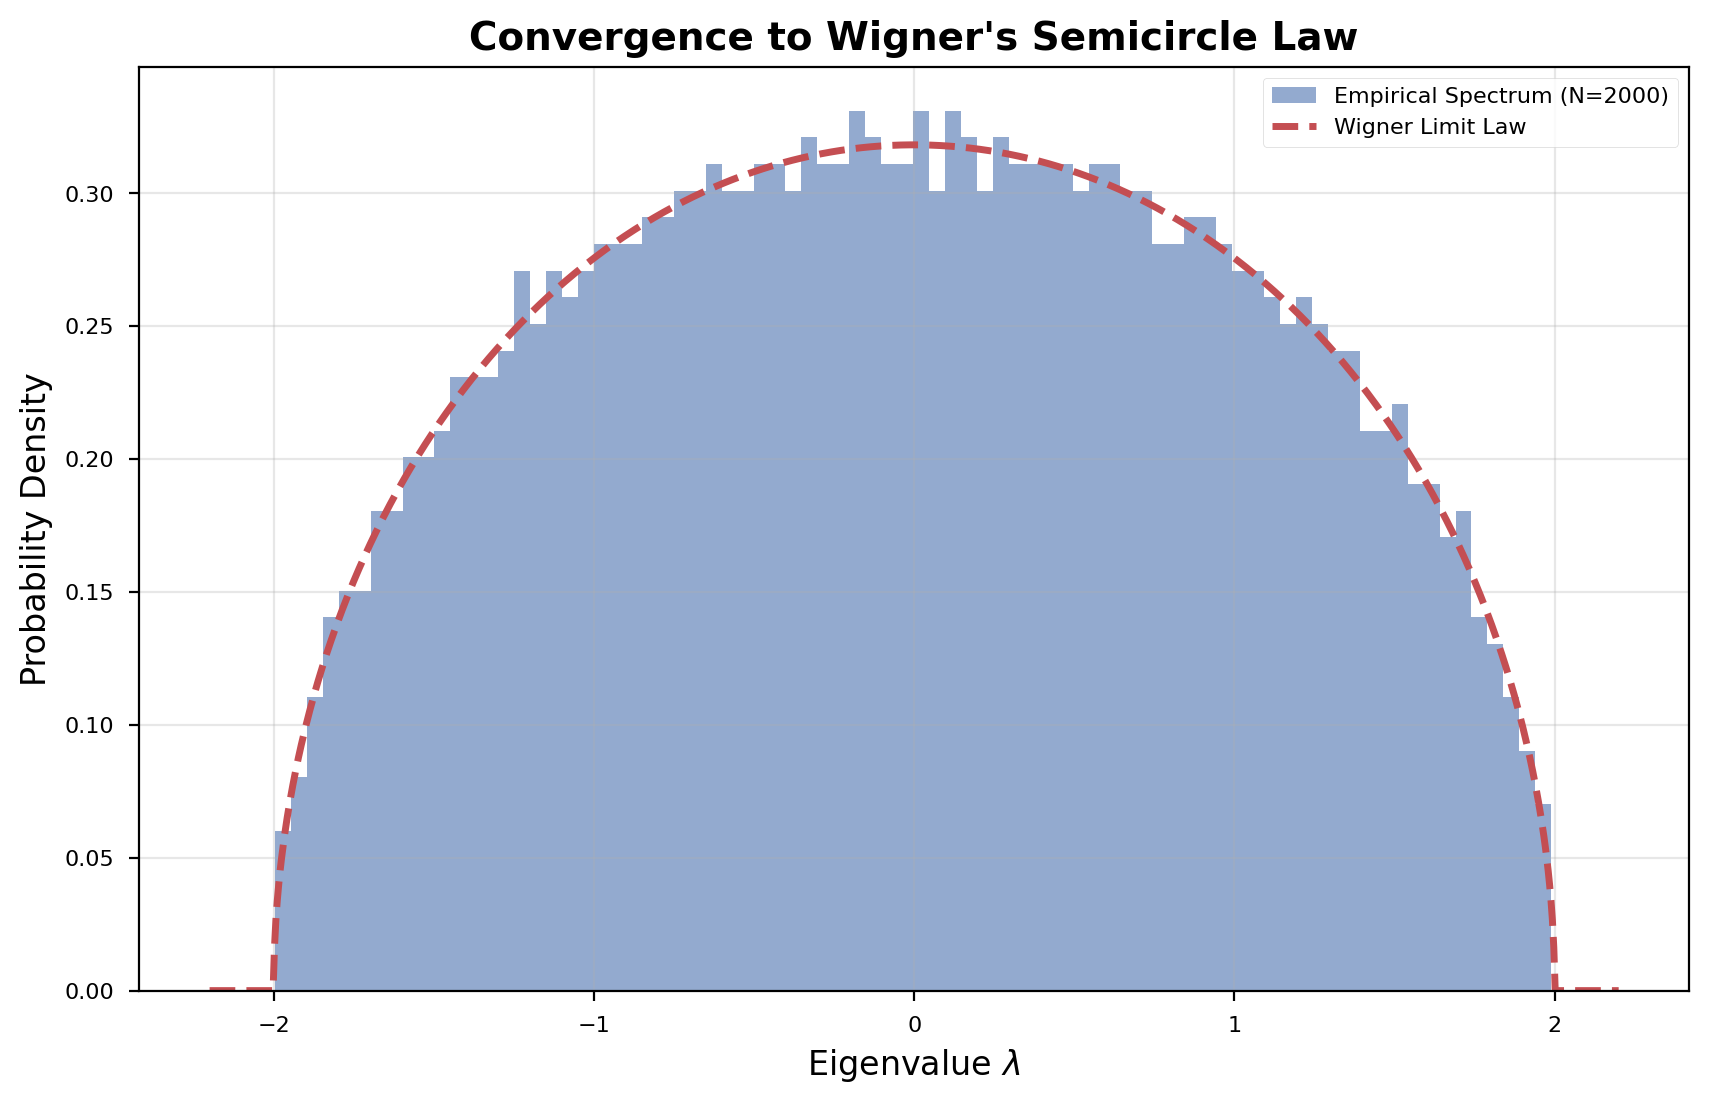

In [4]:
plt.figure(figsize=(10, 6))

# Histogramme empirique
plt.hist(normalized_eigvals, bins=80, density=True, alpha=0.6, 
         color='#4c72b0', label=f'Empirical Spectrum (N={N})')

# Loi théorique
x = np.linspace(-2.2, 2.2, 1000)
y = (1 / (2 * np.pi)) * np.sqrt(np.maximum(0, 4 - x**2))
plt.plot(x, y, color='#c44e52', linewidth=2.5, linestyle='--', label='Wigner Limit Law')

plt.title("Convergence to Wigner's Semicircle Law", fontsize=14, fontweight='bold')
plt.xlabel("Eigenvalue $\lambda$", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.legend(frameon=True)
plt.grid(True, alpha=0.3)
plt.show()